## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [1]:
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from keras.datasets import cifar10

from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# 讀取資料集並作前處理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
# 影像大小
IMAGE_SIZE = (32, 32)

# 影像類別數
NUM_CLASSES = 10

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 256

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 30

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

In [4]:
augment_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

train_batches = augment_generator.flow(x_train, y_train, batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)

In [5]:
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
x = net.output
x = Flatten()(x)

In [7]:
# 增加 DropOut layer
x = Dropout(0.5)(x)

In [8]:
# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

In [9]:
# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

In [10]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# 輸出整個網路結構
print(net_final.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [12]:
# 訓練模型
from datetime import datetime
start_time = datetime.now()
print(f"start time: {start_time}")
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = len(x_train) // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = len(x_test) // BATCH_SIZE,
                        epochs = NUM_EPOCHS)
end_time = datetime.now()
print(f"end time: {end_time}")
print(f"duration = {end_time - start_time}")

start time: 2020-07-12 13:20:27.930038
Epoch 1/30
195/195 [==============================] - 211s 1s/step - loss: 3.5047 - accuracy: 0.1258 - val_loss: 44.4233 - val_accuracy: 0.1037
Epoch 2/30
195/195 [==============================] - 185s 949ms/step - loss: 2.4266 - accuracy: 0.1825 - val_loss: 109.3680 - val_accuracy: 0.0970
Epoch 3/30
195/195 [==============================] - 187s 957ms/step - loss: 2.2000 - accuracy: 0.2484 - val_loss: 45.3256 - val_accuracy: 0.1133
Epoch 4/30
195/195 [==============================] - 189s 968ms/step - loss: 2.0321 - accuracy: 0.3103 - val_loss: 3.8481 - val_accuracy: 0.1596
Epoch 5/30
195/195 [==============================] - 190s 974ms/step - loss: 1.8755 - accuracy: 0.3699 - val_loss: 1.8564 - val_accuracy: 0.3596
Epoch 6/30
195/195 [==============================] - 190s 974ms/step - loss: 1.7231 - accuracy: 0.4262 - val_loss: 1.3891 - val_accuracy: 0.5141
Epoch 7/30
195/195 [==============================] - 191s 979ms/step - loss: 1.5661

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


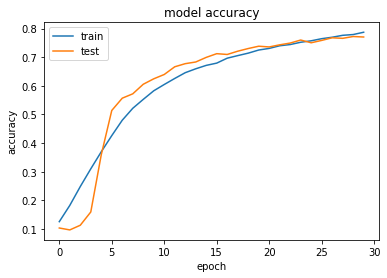

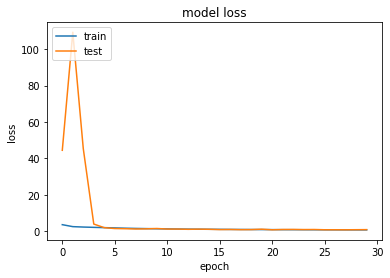

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)